In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
from scipy import sparse 
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from task4.oracles import create_lasso_prox_oracle, create_lasso_nonsmooth_oracle
from task4.optimization import accelerated_proximal_gradient_descent, proximal_gradient_descent, subgradient_method
from task1.optimization import newton

In [5]:
from sklearn.datasets import load_svmlight_file

In [47]:
n = 1000
m = 1000
b_noise_ampl = 0
A = np.random.rand(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true.T) + np.random.rand(m).T*b_noise_ampl
regcoef = 1/n
oracle_prox = create_lasso_prox_oracle(A, b, regcoef)
oracle_sub = create_lasso_nonsmooth_oracle(A, b, regcoef)
x_0 = np.sign(np.random.rand(n))

In [6]:
A_rs, b_rs = load_svmlight_file("datasets/real-sim")
b_rs = sparse.csr_matrix(b_rs)
rs_prox = create_lasso_prox_oracle(A_rs, b_rs, regcoef=1 / A_rs.shape[0])
rs_sub = create_lasso_nonsmooth_oracle(A_rs, b_rs, regcoef=1/A_rs.shape[0])
x_0 = sparse.rand(1, A_rs.shape[1], density=0.1)

In [8]:
%%time
[x_star, status, hist_sub] = subgradient_method(rs_sub, x_0, trace=True, max_iter=100, tolerance=1e-2)

CPU times: user 20.1 s, sys: 313 ms, total: 20.4 s
Wall time: 20.8 s


In [11]:
%%time
[x_star, status, hist_pr] = proximal_gradient_descent(rs_prox, x_0, trace=True, max_iter=100, tolerance=1e-2)

CPU times: user 31 s, sys: 529 ms, total: 31.5 s
Wall time: 33.1 s


In [12]:
%%time
[x_star, status, hist_acc] = accelerated_proximal_gradient_descent(rs_prox, x_0, trace=True, 
                                                                   max_iter=100, tolerance=1e-2)

CPU times: user 50.7 s, sys: 887 ms, total: 51.6 s
Wall time: 54.3 s


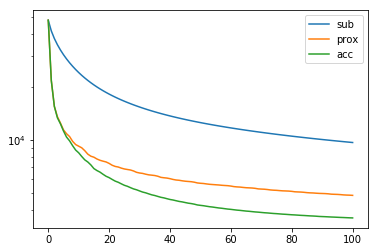

In [13]:
semilogy(hist_sub["duality_gap"], label="sub")
semilogy(hist_pr["duality_gap"], label="prox")
semilogy(hist_acc["duality_gap"], label="acc")
legend()

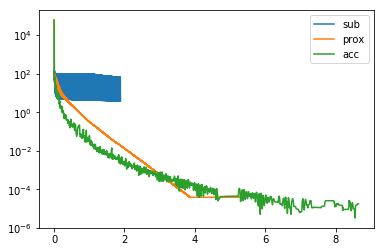

In [76]:
semilogy(hist_sub["time"], hist_sub["duality_gap"], label="sub")
semilogy(hist_pr["time"], hist_pr["duality_gap"], label="prox")
semilogy(hist_acc["time"], hist_acc["duality_gap"], label="acc")
legend()